# Imports

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import model_selection
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt

from tqdm import trange

# Data Preprocessing

In [ ]:
# READ MAP IMAGE

# img = plt.imread("B2L2 Cleaned Floor Plan-1.png")
img = plt.imread("B1L4V2.jpg")

In [ ]:
# df0 = pd.read_json("trackie_data_1.json")
df0 = pd.read_json("trackie_data.json")
df0.describe()

,01FE7VnjryltKDTgfr8P,07d1Bu3i4KwvTshqFzbk,1ASpdLgnD0VGENLgzQvA,21HNiuDtWB3U5DgWytv4,21kSD6uudoYYUL69e5vn,2OdznKYhsTGGY2JfRD8I,2wl8UHdU43pevQvJLuVG,34lbjP1XQIHQsDgaSZHH,37fLmt2LTpj4lEM4lHg4,3LJe7Qqo3LBpzbfyqc3l,3pC0QKniNSiFViLSmc7F,42p5GyiH8RkjiloYvNWX,49ddcF7Nrm2gQr9zqD3y,4Qi4gJQaREVxBUK03GzG,4tsylwC40afCgZIBc1Xc,5lvniyA2UQ2tzSfLY7D7,6Ibci0fwGGisc1d2JBbY,7EYEYRS30NU1ERwMJe0d,92HoGgtWExW2Tx07An4K,9OMDuY95e9SUMk57DfsX,9sibPvXqjJf82G8eyvP6,AAftS4bTujsFV1vatYU6,BJSSh6UH9QTqvTwg2M5x,BOqdnqOHMXjVwXE6DyVw,CaFM4yfcjyA8op1nEv3O,CzRnGzDeRXYhuLSBRhLX,D2e23tbYm9VYFgUqvnVt,EG7kB7AZxjY5y6KMUAgS,F7t5iqWGUwLv8iZcVh2l,FPQ492mqFPC01l4lVLlD,Feulox1JLWklOVougTPQ,G2E63qQtaS5aLPuWaXmB,G5Gr9SldOUXEX6s9dg5b,Gp2D5op3WgcE3gEJDi7F,H3ocoeuAxtrLZ3a6rp9d,HV3eBELX2z2TmKoFmNcW,HnVY7jOqubaCvRTPszY5,JlFG7MSxyw87LPlTfWd4,KIhkTMhB5BctLnveBWsJ,KK7O9KBiOlkfcO2Eu3nF,...,iwmXA3WdWMA9GxS7epcW,jJaBos6ftVJLv7AfNpwO,jXdDSKQHUIhyCwtTLovC,jheDi0h3f8n0CKBsJdLl,jwbCxmeoz5czKBnkMChc,kITOAiY6W6KQVFMQ56sF,kXKLAUq2ylFa0qq7vsyx,keAjJQD3oOdHoh5cnKYe,kw0ekQqb1Eka3s86oqLz,lEnKdm4AYWlvLTBntBWD,lUhOlGXacM1L3UW6j8sc,lguVWaM2ai7OVX4pVnTZ,mGNZFxyoaIeluQYkdZLP,mnAuwXfX1e8tQNx74wgu,msHETAHzq6fvLjsyPnqS,n8RVsTBfSbWRWggLC6lE,nAVT8JVtmlnnYHaiVOah,nFxAa5uC2Phup0iLdisy,nwPxnUEXrekjS6SyM1HY,oKOraNOACTR68G8AsW0O,pqbXSnI846gFNUi0gF68,qRRg9iCuhepgafO1qmcX,rCpyS0p9BCvuj3tQGHxn,rPWjDFlJdiYBeBKJMRV5,szoNRHPhi6YuWINrXQlb,t8xFu44O6RXEj2Epwcjr,tHZGK1VChGWtIASv3NUi,tuz9ZKyqEQ6ilpflfa9z,tx9RONDc2aB4JFYmuHRx,uhqltZLnrdXK7a8YyKj6,vEB7VK6MiuHwmn5CNOur,vHF35S0302dETLqEG7xL,veW0sEzEIZtm3MblkhJR,vzabE7gbJhYO4AXM2HHE,wC79VEM8T3UeDu3HqcJk,xMrOHkkYXMq6W23i5RJJ,xj7d1KnLDKV7PErpERlO,ylAOzxBlKlG7CjtZGG2N,yy7IcbAKprDv8GLC3eM3,zLIAYAwxmlZPrwMzKynX
count,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
unique,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
top,"{'y': 0.129399999976158, 'x': 0.523500025272369}","{'18:64:72:56:82:91': [-82], '18:64:72:55:ea:0...","{'18:64:72:55:c8:72': [-52, -60, -59, -60, -60...","{'18:64:72:56:86:11': [-90], '18:64:72:55:2b:d...","{'18:64:72:56:7e:16': [-87], '18:64:72:56:4b:7...","{'18:64:72:56:3f:10': [-87, -82, -85, -84, -84...","{'08:9b:b9:17:91:be': [-92], '18:64:72:55:cd:1...","{'18:64:72:56:45:d7': [-81, -82, -88, -83, -84...","{'x': 0.5210000276565551, 'y': 0.769999980926513}","{'y': 0.211300000548362, 'x': 0.695599973201751}","{'y': 0.6327999830245971, 'x': 0.6144999861717...","{'y': 0.7993999719619751, 'x': 0.613600015640258}","{'18:64:72:55:c8:75': [-55, -52, -48], '18:64:...","{'18:64:72:56:3f:17': [-87], '18:64:72:56:13:1...","{'18:64:72:56:2d:61': [-83, -82], '18:64:72:56...","{'x': 0.6929000020027161, 'y': 0.5382000207901}","{'18:64:72:56:54:77': [-83, -83], 'c8:3a:35:7c...","{'18:64:72:55:c7:87': [-65, -65, -67, -67, -66...","{'y': 0.5806000232696531, 'x': 0.69319999217987}","{'x': 0.615800023078918, 'y': 0.684599995613098}","{'18:64:72:55:ea:10': [-80, -81, -83, -82], '1...","{'y': 0.9406999945640561, 'x': 0.698300004005432}","{'18:64:72:55:ea:11': [-79, -79, -82, -84, -83...","{'18:64:72:55:fc:f6': [-85], '18:64:72:55:c7:9...","{'18:64:72:56:11:d1': [-81, -80], '18:64:72:56...","{'18:64:72:56:3f:10': [-77, -81], '18:64:72:56...","{'18:64:72:56:45:d3': [-87, -86, -85, -87], '1...","{'x': 0.611100018024444, 'y': 0.35429999232292...","{'18:64:72:56:45:22': [-81], '18:64:72:55:c6:2...","{'x': 0.5256000161170961, 'y': 0.324800014495849}","{'18:64:72:56:47:51': [-92, -91], '18:64:72:56...","{'y': 0.48530000448226907, 'x': 0.693300008773...","{'18:64:72:56:7f:b1': [-90], 'c8:3a:35:7c:72:1...","{'18:64:72:56:87:16': [-76, -79, -74, -77, -82...",H3ocoeuAxtrLZ3a6rp9d,"{'18:64:72:56:57:97': [-79, -79, -83], '48:46:...",HnVY7jOqubaCvRTPszY5,"{'y': 0.9954000115394591, 'x': 0.698499977588653}","{'x': 0.610700011253356, 'y': 0.32060000300407...","{'18:64:7

120


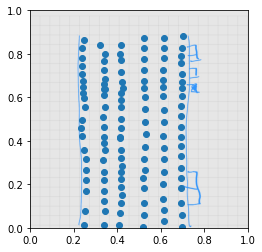

In [ ]:
allX = []
allY = []
for id in df0:
  thisx =     df0[id]['location']['x']
  thisy = 1 - df0[id]['location']['y']
  #if (thisx not in allX) and (thisy not in allY):
  allX.append(thisx)
  allY.append(thisy)

print(len(allX))

fig, ax1 = plt.subplots(figsize=(4,4))
ax1.imshow(img, extent=[0, 1, 0, 1])
ax1.scatter(allX, allY)

In [ ]:
# make training data into classes

LEGAL_POINTS = []
for id in df0:
  thisx = df0[id]['location']['x']
  thisy = df0[id]['location']['y']
  LEGAL_POINTS.append((thisx, thisy))
LEGAL_POINTS = np.array(LEGAL_POINTS)

print(LEGAL_POINTS.shape)

def closestLegalId(unknown):
  dist_2 = np.sum((LEGAL_POINTS - unknown)**2, axis=1)
  return np.argmin(dist_2)

import json

with open("LEGAL_POINTS.json", "w+") as f:
  package = {
      "LEGAL_POINTS": LEGAL_POINTS.tolist()
  }
  f.write(json.dumps(package))

(120, 2)


In [ ]:
ls -lash

total 1.6M
4.0K drwxr-xr-x 1 root root 4.0K Apr 22 06:49 ./
4.0K drwxr-xr-x 1 root root 4.0K Apr 22 06:40 ../
124K -rw-r--r-- 1 root root 121K Apr 22 06:47 B1L4V2.jpg
4.0K drwxr-xr-x 4 root root 4.0K Apr  7 13:35 .config/
8.0K -rw-r--r-- 1 root root 4.9K Apr 22 06:49 LEGAL_POINTS.json
4.0K drwxr-xr-x 1 root root 4.0K Apr  7 13:36 sample_data/
1.4M -rw-r--r-- 1 root root 1.4M Apr 22 06:47 trackie_data.json


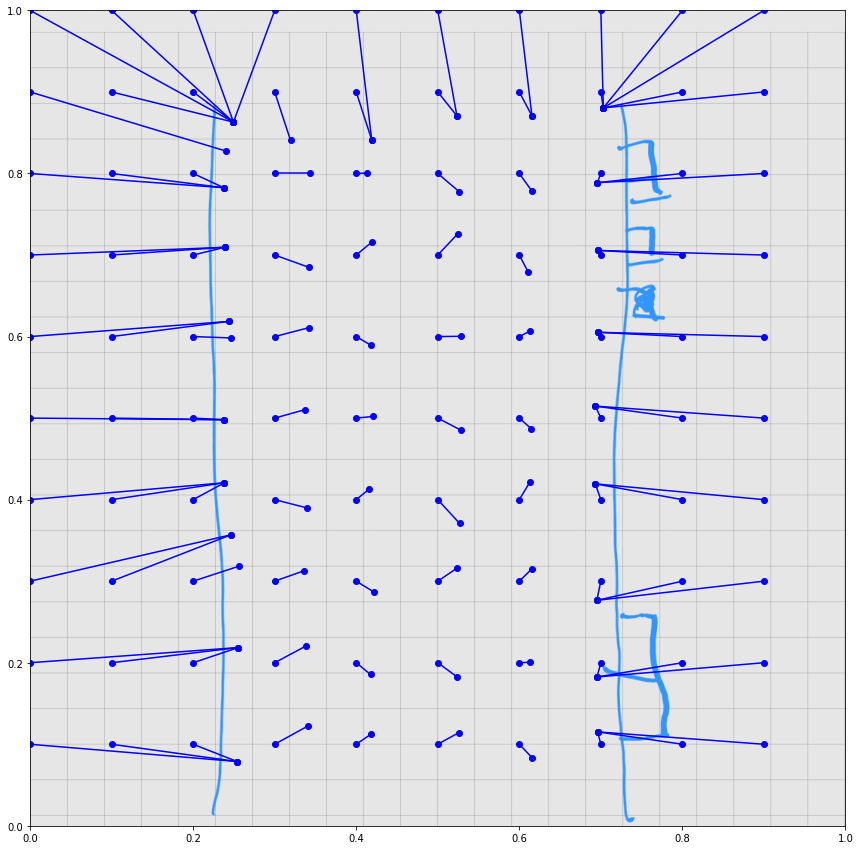

In [ ]:
# plot mappings
fig, ax1 = plt.subplots(figsize=(15,15))
ax1.imshow(img, extent=[0, 1, 0, 1])

for x in range(0, 100, 10):
  for y in range(0, 100, 10):
    xx, yy = LEGAL_POINTS[closestLegalId([x/100, y/100])]
    ax1.plot([x/100, xx],[1 - y/100, 1 - yy],'bo-')

In [ ]:
# FIND UNIQUE BSSIDS FOR ALL MAPPED LOCATIONS

uniqssid = {}
for id in df0:
  for ssid in df0[id].data:
    if not (ssid in uniqssid):
      uniqssid[ssid] = {
          'totalcount': 0,
          'count': 0,
          'rssimin':  100,
          'rssimax': -999,
          'rssirange': -1
      }
    rssilist = df0[id].data[ssid]
    uniqssid[ssid]['totalcount'] += len(rssilist)
    uniqssid[ssid]['count'] += 1
    uniqssid[ssid]['rssimin'] = min(uniqssid[ssid]['rssimin'], min(rssilist))
    uniqssid[ssid]['rssimax'] = max(uniqssid[ssid]['rssimax'], max(rssilist))
    uniqssid[ssid]['rssirange'] = uniqssid[ssid]['rssimax'] - uniqssid[ssid]['rssimin']

In [ ]:
# CONVERT TO A LIST OF DICTS 

uniqssidlist = []
for ssid in uniqssid:
  obj = uniqssid[ssid]
  uniqssidlist.append({
    'ssid':       ssid,
    'totalcount': obj['totalcount'],
    'count':      obj['count'],
    'rssimin':    obj['rssimin'],
    'rssimax':    obj['rssimax'],
    'rssirange':  obj['rssirange'],
  })

In [ ]:
# SORT THE LIST ACCORDING TO COUNT, RSSIRANGE AND TOTAL COUNT

def sortkeypicker(keynames):
    negate = set()
    for i, k in enumerate(keynames):
        if k[:1] == '-':
            keynames[i] = k[1:]
            negate.add(k[1:])
    def getit(adict):
       composite = [adict[k] for k in keynames]
       for i, (k, v) in enumerate(zip(keynames, composite)):
           if k in negate:
               composite[i] = -v
       return composite
    return getit

uniqssidlistsorted = sorted(uniqssidlist, key=sortkeypicker(['-count', '-rssirange', '-totalcount']))

In [ ]:
# SIEVE OUT GOOD SSIDS 

NUM_GOOD_SSID = len(uniqssidlistsorted) * 0.9
print(NUM_GOOD_SSID)
goodssids = []
for i in uniqssidlistsorted:
  goodssids.append(i['ssid'])

1218


In [ ]:
with open("B1L4V2_good_ssids.txt", "w+") as f:
  for goodssid in goodssids:
    item = goodssid + ", "
    f.write(item)

In [ ]:
# CREATE NEW DATAFRAME WITH GOOD SSIDS ONLY 

target_cols = ['locX', 'locY']
rssicols = [f'r{i}v' for i in range(NUM_GOOD_SSID)]
rssicols.extend([f'r{i}rssi' for i in range(NUM_GOOD_SSID)])

all_cols = []
all_cols.extend(target_cols)
all_cols.extend(rssicols)

df1 = pd.DataFrame(columns=all_cols)

for id in df0:
  datarow = {
      'locX': df0[id]['location']['x'],
      'locY': df0[id]['location']['y']
  }
  cleanrssi = {}
  for ssid in df0[id].data:
    cleanrssi[ssid] = np.mean(df0[id].data[ssid])
  for i in range(len(goodssids)):
    if goodssids[i] in cleanrssi:
      datarow[f'r{i}v']     = 1
      # NORMALISE WITH -100 
      datarow[f'r{i}rssi']  = cleanrssi[goodssids[i]] / -100
    else:
      datarow[f'r{i}v']     = 0
      datarow[f'r{i}rssi']  = -1
  df1 = df1.append(datarow, ignore_index=True)

In [ ]:
df1.describe()

,locX,locY,r0v,r1v,r2v,r3v,r4v,r5v,r6v,r7v,r8v,r9v,r10v,r11v,r12v,r13v,r14v,r15v,r16v,r17v,r18v,r19v,r20v,r21v,r22v,r23v,r24v,r25v,r26v,r27v,r28v,r29v,r30v,r31v,r32v,r33v,r34v,r35v,r36v,r37v,...,r1178rssi,r1179rssi,r1180rssi,r1181rssi,r1182rssi,r1183rssi,r1184rssi,r1185rssi,r1186rssi,r1187rssi,r1188rssi,r1189rssi,r1190rssi,r1191rssi,r1192rssi,r1193rssi,r1194rssi,r1195rssi,r1196rssi,r1197rssi,r1198rssi,r1199rssi,r1200rssi,r1201rssi,r1202rssi,r1203rssi,r1204rssi,r1205rssi,r1206rssi,r1207rssi,r1208rssi,r1209rssi,r1210rssi,r1211rssi,r1212rssi,r1213rssi,r1214rssi,r1215rssi,r1216rssi,r1217rssi
count,120.000000,120.000000,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.00000,120.00000,120.00000,120.00000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.465248,0.537291,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.991667,0.991667,0.991667,0.991667,0.991667,0.991667,0.991667,0.991667,0.991667,0.983333,0.983333,0.983333,0.97500,0.97500,0.97500,0.97500,...,-0.984417,-0.984417,-0.984250,-0.984833,-0.984250,-0.984417,-0.984333,-0.983917,-0.983917,-0.984167,-0.984250,-0.984333,-0.983833,-0.983917,-0.984500,-0.984500,-0.984583,-0.983917,-0.984417,-0.984583,-0.984667,-0.984417,-0.984750,-0.984417,-0.984583,-0.984583,-0.984667,-0.984417,-0.984500,-0.984083,-0.984417,-0.984250,-0.984500,-0.984500,-0.983833,-0.984083,-0.984083,-0.984500,-0.984083,-0.984333
std,0.155229,0.253949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091287,0.091287,0.091287,0.091287,0.091287,0.091287,0.091287,0.091287,0.091287,0.128556,0.128556,0.128556,0.15678,0.15678,0.15678,0.15678,...,0.170707,0.170707,0.172533,0.166143,0.172533,0.170707,0.171620,0.176184,0.176184,0.173445,0.172533,0.171620,0.177097,0.176184,0.169794,0.169794,0.168881,0.176184,0.170707,0.168881,0.167968,0.170707,0.167055,0.170707,0.168881,0.168881,0.167968,0.170707,0.169794,0.174358,0.170707,0.172533,0.169794,0.169794,0.177097,0.174358,0.174358,0.169794,0.174358,0.171620
min,0.234800,0.119600,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.339800,0.328400,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.420150,0.524850,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

In [ ]:
df1.iloc[0]

locX         0.5235
locY         0.1294
r0v          1.0000
r1v          1.0000
r2v          1.0000
              ...  
r1213rssi   -1.0000
r1214rssi   -1.0000
r1215rssi   -1.0000
r1216rssi   -1.0000
r1217rssi   -1.0000
Name: 0, Length: 2438, dtype: float64

In [ ]:
# SET X AND Y AND SPLIT DATA INTO TRAINING AND TEST SET 

X = df1[rssicols]
y = df1[['locX', 'locY']]
y_x = df1['locX']
y_y = df1['locY']

In [ ]:
y_legal = []
for row in y.to_numpy():
  y_legal.append(closestLegalId([row[0], row[1]]))
y_legal = np.array(y_legal)
y_legal.shape

(120,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
print(X_train.shape, y_train.shape)

(108, 2436) (108, 2)


# SKLEARN CLASSIFIERS

In [ ]:
!ls -lash

total 76M
4.0K drwxr-xr-x 1 root root 4.0K Apr 19 10:13  .
4.0K drwxr-xr-x 1 root root 4.0K Apr 19 08:29  ..
528K -rw-r--r-- 1 root root 527K Apr 19 08:31 'B2L2 Cleaned Floor Plan-1.png'
4.0K drwxr-xr-x 4 root root 4.0K Apr  7 13:35  .config
 24K -rw-r--r-- 1 root root  24K Apr 19 09:15  good_ssids.txt
4.0K drwxr-xr-x 2 root root 4.0K Apr 19 08:31  .ipynb_checkpoints
 24K -rw-r--r-- 1 root root  21K Apr 19 09:55  LEGAL_POINTS.json
 63M -rw-r--r-- 1 root root  63M Apr 19 10:13  ragul1.joblib
4.0K drwxr-xr-x 1 root root 4.0K Apr  7 13:36  sample_data
 12M -rw-r--r-- 1 root root  12M Apr 19 08:34  trackie_data_1.json


## EXTRA TREES

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
# xtclassifier = ExtraTreesClassifier(n_estimators=256).fit(X_train, y_train)
xtclassifier = ExtraTreesClassifier(n_estimators=256).fit(X, y_legal)

In [ ]:
print(xtclassifier.score(X_test, y_test))
print(mean_squared_error(y_test, xtclassifier.predict(X_test)))

1.0
0.0


In [ ]:
import joblib

filename = "model.joblib"
joblib.dump(xtclassifier, filename, compress=2)

['model.joblib']

In [ ]:
ls -lash

total 3.4M
4.0K drwxr-xr-x 1 root root 4.0K Apr 22 06:50 ./
4.0K drwxr-xr-x 1 root root 4.0K Apr 22 06:40 ../
 24K -rw-r--r-- 1 root root  23K Apr 22 06:49 B1L4V2_good_ssids.txt
124K -rw-r--r-- 1 root root 121K Apr 22 06:47 B1L4V2.jpg
4.0K drwxr-xr-x 4 root root 4.0K Apr  7 13:35 .config/
8.0K -rw-r--r-- 1 root root 4.9K Apr 22 06:49 LEGAL_POINTS.json
1.8M -rw-r--r-- 1 root root 1.8M Apr 22 06:51 model.joblib
4.0K drwxr-xr-x 1 root root 4.0K Apr  7 13:36 sample_data/
1.4M -rw-r--r-- 1 root root 1.4M Apr 22 06:47 trackie_data.json


## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(max_iter=10000, verbose=True, hidden_layer_sizes=(1024, 512, 256), learning_rate='adaptive')
model.fit(X_train, y_train)

print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

Iteration 1, loss = 6.31587154
Iteration 2, loss = 6.11778063
Iteration 3, loss = 6.02563482
Iteration 4, loss = 5.85623137
Iteration 5, loss = 5.68546072
Iteration 6, loss = 5.45076053
Iteration 7, loss = 5.11320785
Iteration 8, loss = 4.75504952
Iteration 9, loss = 4.31244758
Iteration 10, loss = 3.83890411
Iteration 11, loss = 3.29469818
Iteration 12, loss = 2.83621287
Iteration 13, loss = 2.40017191
Iteration 14, loss = 1.94825170
Iteration 15, loss = 1.54315697
Iteration 16, loss = 1.19111655
Iteration 17, loss = 0.86091107
Iteration 18, loss = 0.63562568
Iteration 19, loss = 0.46662008
Iteration 20, loss = 0.37347552
Iteration 21, loss = 0.26280232
Iteration 22, loss = 0.21787809
Iteration 23, loss = 0.14343548
Iteration 24, loss = 0.12458438
Iteration 25, loss = 0.07942170
Iteration 26, loss = 0.06070364
Iteration 27, loss = 0.05276725
Iteration 28, loss = 0.03817296
Iteration 29, loss = 0.02980325
Iteration 30, loss = 0.02944858
Iteration 31, loss = 0.02136184
Iteration 32, los

## SVC

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC().fit(X_train, y_train)

In [ ]:
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.0
93878.45098039215


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.0
49999.117647058825


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model = GaussianNB().fit(X_train, y_train)
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.0
96859.27450980392


## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=128).fit(X_train, y_train)
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.0
53986.0


## ONE VS REST

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(ExtraTreesClassifier(n_estimators=256)).fit(X_train, y_train)
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.0
45941.294117647056


In [ ]:
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(ExtraTreesClassifier(n_estimators=256)).fit(X, y_legal)
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

1.0
0.0


In [ ]:
import joblib

joblib.dump(model, 'model.joblib', compress=1)

['model.joblib']

MSE: 0.0


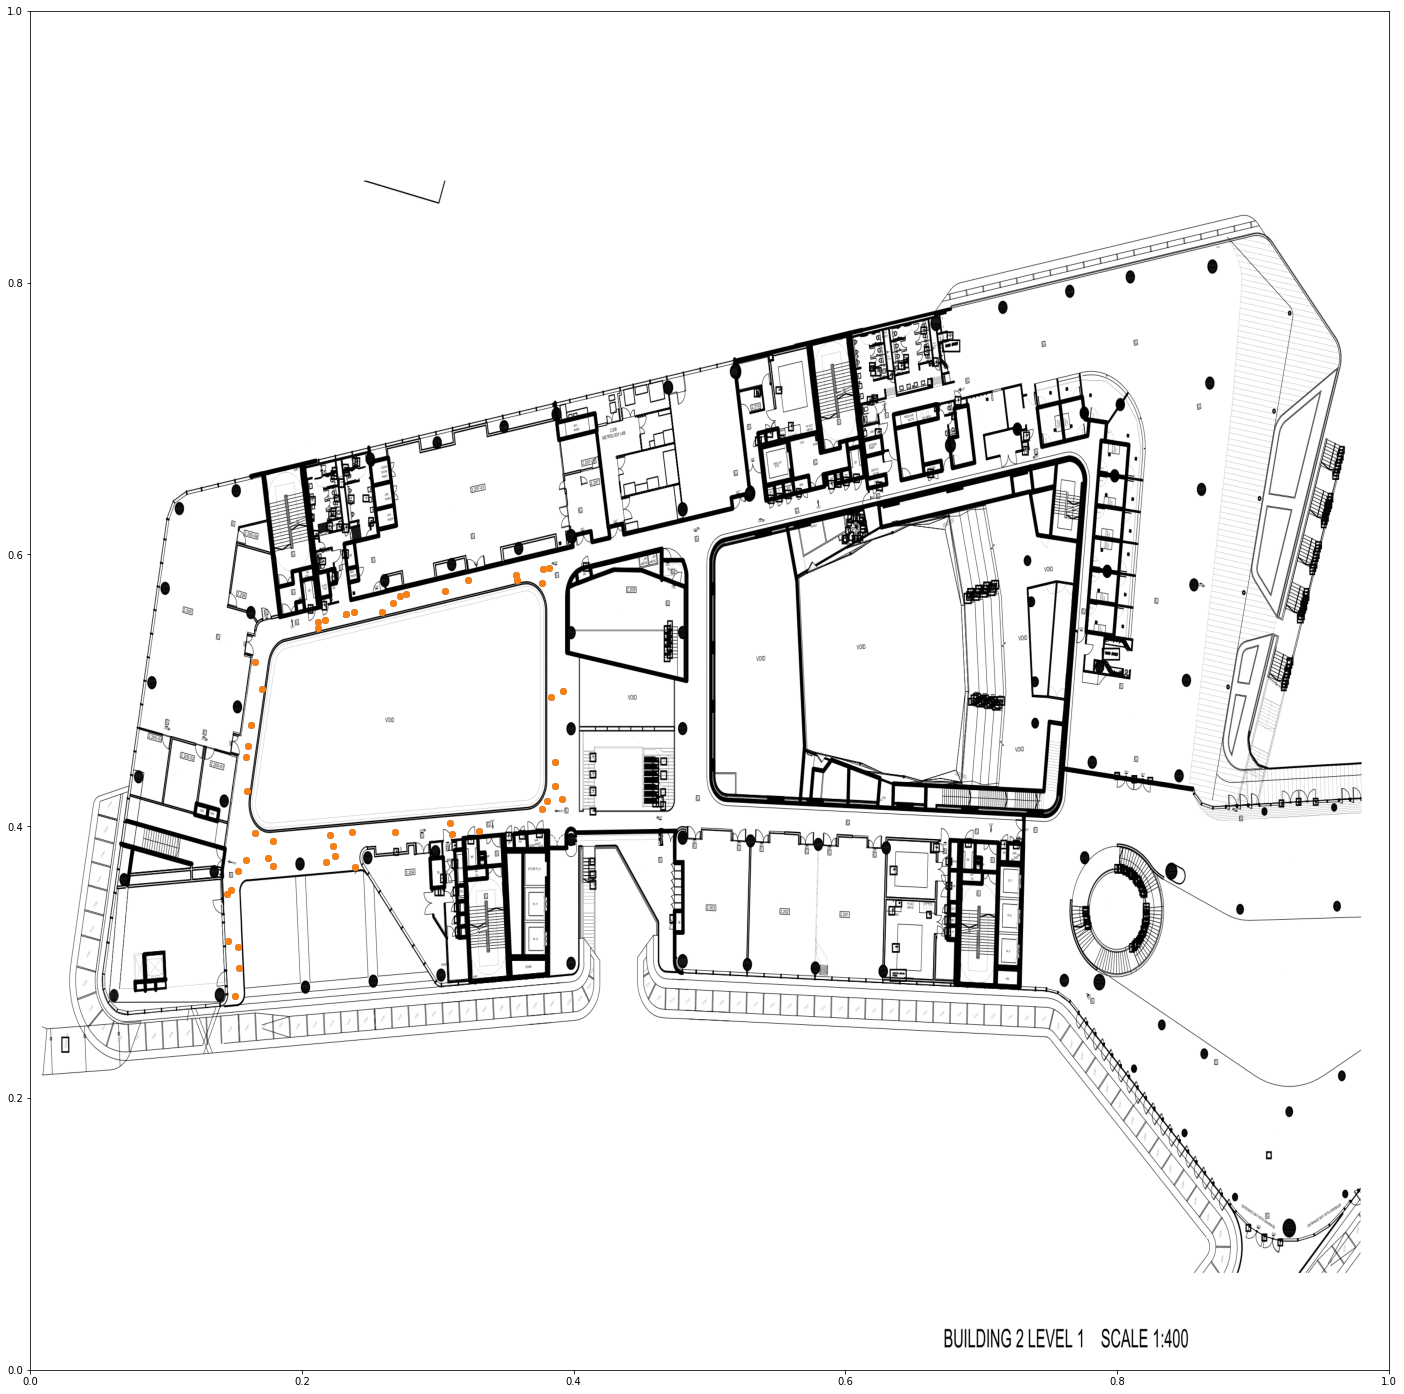

In [ ]:
# discrete point predictions
fig, ax1 = plt.subplots(figsize=(25,25))
ax1.imshow(img, extent=[0, 1, 0, 1])

y_pred = [ LEGAL_POINTS[i] for i in model.predict(X_test) ]
y_real = [ LEGAL_POINTS[i] for i in y_test ]

ax1.scatter([ i[0] for i in y_pred ], [ 1 - i[1] for i in y_pred ])
ax1.scatter([ i[0] for i in y_real ], [ 1 - i[1] for i in y_real ])

for i in range(len(y_test)):
  ax1.plot([y_real[i][0], y_pred[i][0]], [1 - y_real[i][1], 1 - y_pred[i][1]],'g-')

print("MSE:", mean_squared_error(y_pred, y_real))

# SKLEARN REGRESSORS

## EXTRA TREES

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
reg = ExtraTreesRegressor(n_estimators=100).fit(X, y)

In [ ]:
print(reg.score(X_test, y_test))
print(mean_squared_error(y_test, reg.predict(X_test)))

1.0
1.0021255477294916e-31


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [ ]:
import joblib

filename = "model.joblib"
joblib.dump(reg, filename)

['model.joblib']

## RANDOM FOREST REGRESSOR

In [ ]:
model = RandomForestRegressor(n_estimators=NUM_GOOD_SSID)
model.fit(X, y)

print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.9929230572408646
6.01682820180365e-05


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [ ]:
import joblib

filename = "B2L2NEW_RF.joblib"
joblib.dump(model, filename)

['B2L2NEW_RF.joblib']

In [ ]:
model.fit(X, y)
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.9916732429756144
7.079422315408259e-05


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## MLP REGRESSOR

In [ ]:
model = MLPRegressor(max_iter=10000, verbose=True, hidden_layer_sizes=(512, 256, 128), learning_rate='adaptive')
model.fit(X_train, y_train)

print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

Iteration 1, loss = 0.26254572
Iteration 2, loss = 0.08324245
Iteration 3, loss = 0.02048150
Iteration 4, loss = 0.01588994
Iteration 5, loss = 0.01243099
Iteration 6, loss = 0.01022079
Iteration 7, loss = 0.00679959
Iteration 8, loss = 0.00667271
Iteration 9, loss = 0.00532613
Iteration 10, loss = 0.00573251
Iteration 11, loss = 0.00495945
Iteration 12, loss = 0.00536396
Iteration 13, loss = 0.00442839
Iteration 14, loss = 0.00484225
Iteration 15, loss = 0.00411374
Iteration 16, loss = 0.00448046
Iteration 17, loss = 0.00401874
Iteration 18, loss = 0.00416175
Iteration 19, loss = 0.00386408
Iteration 20, loss = 0.00399606
Iteration 21, loss = 0.00384743
Iteration 22, loss = 0.00336899
Iteration 23, loss = 0.00357457
Iteration 24, loss = 0.00336476
Iteration 25, loss = 0.00349820
Iteration 26, loss = 0.00312773
Iteration 27, loss = 0.00325295
Iteration 28, loss = 0.00296509
Iteration 29, loss = 0.00285214
Iteration 30, loss = 0.00346038
Iteration 31, loss = 0.00296739
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## XGBOOST

In [ ]:
import xgboost as xg
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

In [ ]:
model = MultiOutputRegressor(xg.XGBRegressor(max_depth=32, n_estimators=128))
model.fit(X_train, y_train)

print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

[14:00:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.927830144271482
0.0009253481445171505


## KNN REGRESSOR 

In [ ]:
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)

print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.7264644218323808
0.0030888896518936155


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## Decision Tree

In [ ]:
dtree = DecisionTreeRegressor(max_depth=60, min_samples_leaf=8)

dtree.fit(X_train, y_train)

print(dtree.score(X_test, y_test))
print(mean_squared_error(y_test, dtree.predict(X_test)))

0.6734796374708528
0.0036872182247926306


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## GAUSSIAN REGRESSOR 

In [ ]:
model = GaussianProcessRegressor(1 * RBF(1.0))
model.fit(X_train, y_train)

print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

-1.8342023316604228
0.03200511725854531


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## ITERATE PLUS PLOT

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


 Test 0 r2 score: 0.8167704915813856
 Test 0 mse : 0.0060988229861406095


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


 Test 1 r2 score: 0.6957438813884318
 Test 1 mse : 0.01567325747834621


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


 Test 2 r2 score: 0.8770976063102853
 Test 2 mse : 0.005456232188542841


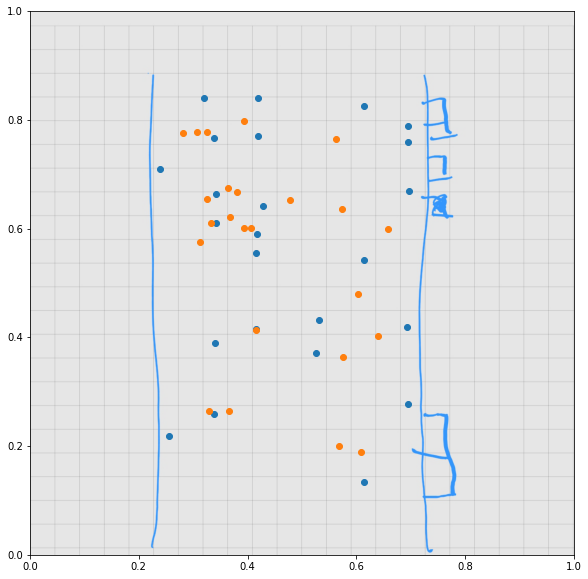

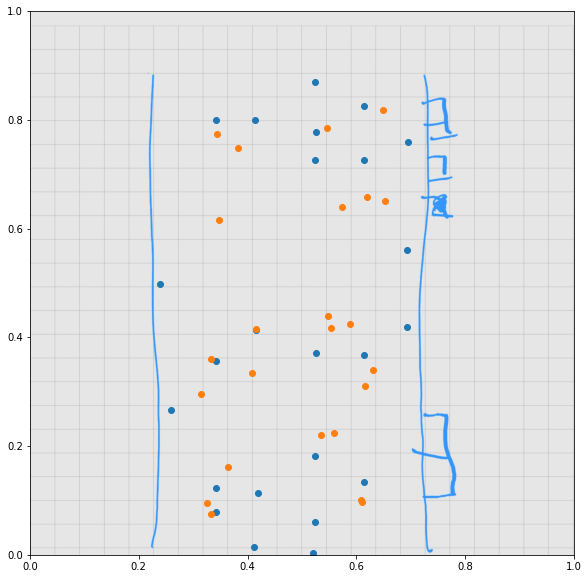

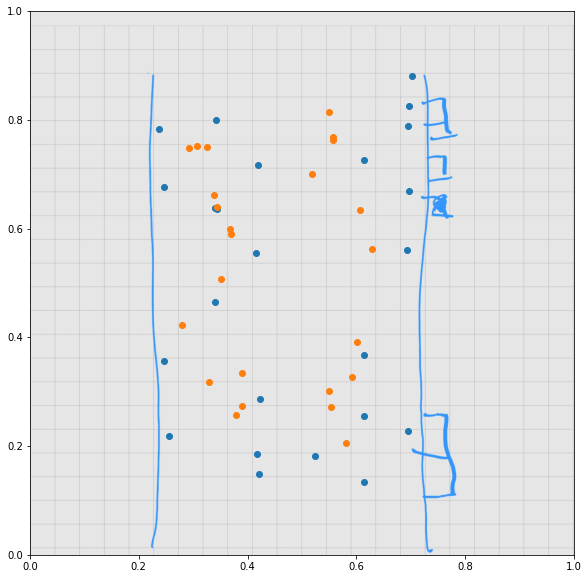

In [ ]:
for i in range(3):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  # model = RandomForestRegressor(max_depth=32, n_estimators=256)
  # model = MultiOutputRegressor(xg.XGBRegressor(max_depth=32, n_estimators=128))
  # model = MLPRegressor(max_iter=10000, hidden_layer_sizes=(1024, 512, 256, 128, 64, 32))
  # model = GaussianProcessRegressor(1 * RBF(1.0))
  model = ExtraTreesRegressor(n_estimators=128)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f" Test {i} r2 score: {model.score(X_test, y_test)}")
  print(f" Test {i} mse : {mean_squared_error(y_test, y_pred)}")
  y_pred_x = [ x for x, y in model.predict(X_test)]
  y_pred_y = [ 1 - y for x, y in model.predict(X_test)]
  fig, ax1 = plt.subplots(figsize=(10,10))
  ax1.imshow(img, extent=[0, 1, 0, 1])
  ax1.scatter(y_test['locX'].tolist(), (1 - y_test['locY']).tolist())
  ax1.scatter(y_pred_x, y_pred_y)

# EXPORT ONNX

In [ ]:
!pip install skl2onnx

     |████████████████████████████████| 235kB 5.8MB/s 
     |████████████████████████████████| 14.5MB 271kB/s 
     |████████████████████████████████| 71kB 5.1MB/s 


In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

onnxtest = RandomForestRegressor(max_depth=16, n_estimators=32)
onnxtest.fit(X, y)
onnxtest.score(X_test, y_test)


The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


0.9934290235626841

In [ ]:
initial_type = [('float_input', FloatTensorType([None, None]))]
onx = convert_sklearn(onnxtest, initial_types=initial_type)
with open("B2L2NEW_RandomForest1.onnx", "wb") as f:
    f.write(onx.SerializeToString())

the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
the n_classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.


# EXPORT TO JAVA

In [ ]:
!pip install m2cgen

     |████████████████████████████████| 81kB 3.5MB/s 


In [ ]:
import m2cgen

In [ ]:
java_code = m2cgen.export_to_java(model)
with open('javacode1.java', 'w') as java:
  java.write(java_code)

# EXPORT PMML

In [ ]:
!pip install sklearn2pmml

     |████████████████████████████████| 5.9MB 5.7MB/s 
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.69.0-cp37-none-any.whl size=5862061 sha256=2dee05d0bfe8a2daf30f9dc4bb01bdc5a2e97ec2c7424bdf860c38452acfd188
  Stored in directory: /root/.cache/pip/wheels/6f/c0/0a/21eb70438fcd763e3a52ad2ac5618072f304aea6709f04e37f
Successfully built sklearn2pmml


In [ ]:
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml
from sklearn_pandas import DataFrameMapper

In [ ]:
rf = PMMLPipeline([
	("regressor", RandomForestRegressor(max_depth=16, n_estimators=32))
])
rf.fit(X, y)
rf.score(X_test, y_test)

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


0.990772940495109

In [ ]:
default_mapper = DataFrameMapper([i for i in rssicols])

In [ ]:
sklearn2pmml(pipeline, "B2L2NEW_RandomForest.pmml")

Standard output is empty
Standard error:
Apr 01, 2021 4:48:44 AM org.jpmml.sklearn.Main run
INFO: Parsing PKL..
Apr 01, 2021 4:48:45 AM org.jpmml.sklearn.Main run
INFO: Parsed PKL in 553 ms.
Apr 01, 2021 4:48:45 AM org.jpmml.sklearn.Main run
INFO: Converting PKL to PMML..
Apr 01, 2021 4:48:45 AM org.jpmml.sklearn.Main run
SEVERE: Failed to convert PKL to PMML
java.lang.IllegalArgumentException: Expected 1 element(s), got 2 element(s)
	at org.jpmml.python.ClassDictUtil.checkSize(ClassDictUtil.java:64)
	at sklearn2pmml.pipeline.PMMLPipeline.encodePMML(PMMLPipeline.java:129)
	at org.jpmml.sklearn.Main.run(Main.java:233)
	at org.jpmml.sklearn.Main.main(Main.java:151)

Exception in thread "main" java.lang.IllegalArgumentException: Expected 1 element(s), got 2 element(s)
	at org.jpmml.python.ClassDictUtil.checkSize(ClassDictUtil.java:64)
	at sklearn2pmml.pipeline.PMMLPipeline.encodePMML(PMMLPipeline.java:129)
	at org.jpmml.sklearn.Main.run(Main.java:233)
	at org.jpmml.sklearn.Main.main(Main.

RuntimeError: ignored

In [ ]:
!pip install nyoka

     |████████████████████████████████| 348kB 6.7MB/s 


In [ ]:
from sklearn.pipeline import Pipeline
from nyoka import skl_to_pmml

In [ ]:
pipelineX = Pipeline([
	("regressor", RandomForestRegressor(max_depth=16, n_estimators=32))
])

pipelineX.fit(X, y_x)
pipelineX.score(X_testx, y_testx)

0.9916798742735005

In [ ]:
pipelineY = Pipeline([
	("regressor", RandomForestRegressor(max_depth=16, n_estimators=32))
])

pipelineY.fit(X, y_y)
pipelineX.score(X_testy, y_testy)

-10.954542525938598

In [ ]:
skl_to_pmml(pipeline=pipelineX,col_names=rssicols,target_name='locX',pmml_f_name="B2L2NEW_RandomForestX.pmml")
# skl_to_pmml(pipeline=pipelineY,col_names=rssicols,target_name='locY',pmml_f_name="B2L2NEW_RandomForestY.pmml")

the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
the n_classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.


# DEBUG

In [ ]:
y_pred_x = [ x for x, y in model.predict(X_test)]
y_pred_y = [ 1 - y for x, y in model.predict(X_test)]

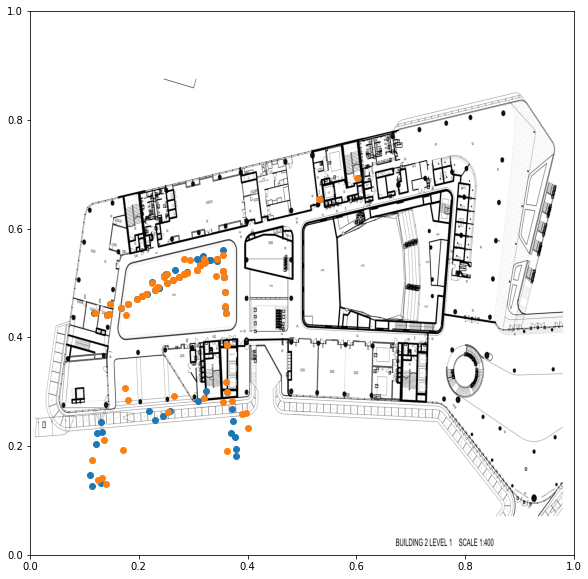

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, extent=[0, 1, 0, 1])
ax.scatter(y_test['locX'].tolist(), (1 - y_test['locY']).tolist())
ax.scatter(y_pred_x, y_pred_y)

In [ ]:
df2 = pd.read_json("trackie_data.json")
df2.describe()

,0AaNcUL1SaGYjElaiPI2,0SkjrS8UfnJhW8M6ycBn,0edeOrr8wHjjhP6TymvD,0yzEK946gUWxEmBzrff8,16IJ9fK9kZUPbbIU3Yq2,1OE6XFClkUIofya4cR4l,1Qxp5UlFeukr75vFPMIg,1YkOxlRGBh7E6JRSudo4,1oXntRtm1M4Hxs28d5pH,2WF7ot62VsAuu0tJYgSw,2ivr0r3RNa1uNqeQrcnE,2yo9F3QiPaAcKt5LiNbu,3A3BLLdXyTLmFfSWg9xP,3StucIEeSvrm4xQxbd9S,3kXEOsXc9BN07RQEIYWM,4ANzA5j9vgvGe3yyW6oK,4ZnT0B9J56xrsOixqBhY,4e1QCuXZkdwBCGs0IlVy,4giUN2xG5US5S9lO419d,4p8GXWMgexAk86Om6ZrN,4qmuNfagguYS5kTaGV8Z,4rZrOJeTxtSDGgjQzmVz,4xNaNPYk5Kab4cAAaV28,5LRwhaJHDy1CG8IosKdB,5n2T9ss6CMTpT3QP1ZUl,5qMlr16h4V9gkRCUsqB9,5ttp6cmOXpDvYWQRgw30,6KXawNLNni4Aad14A9k3,752AnnHzjL4maRJ7JTOO,7BHG9nRTXUDOuKzLWPsu,7Npqc7bmMkvnnbLneNRw,7Rw2aQtURfXAINC5CKro,7RytlT9RSgr585uXOSVJ,7Tib3W98RvKA135GYQvS,7ZAUSiW0W97UuzFQqgXz,7pkVhQ91urMRLsKEMIXO,7sjFdT6AHtgeSlnn8D7L,814pggiYBl1Ksfrzb3I2,8NWT5DFu2Ka6Shq7qkB1,8YCUBVtJ4dM2jQoBZ2Lq,...,t6RHpjaYkjIZ1tcWSjD3,tCBoDLwICJZPYP0hrBQw,tKIMCvV3rq3QlAyCL2yf,tLqpcgKSnx7aWZXfh7Mk,tOps31m1o1vLcRw0CF2w,tnF8FuJ9ddlrbwPsbKH4,ttqHqPl1LUMliAhtDFAy,twQXaRH2Ehhg9lReyd9A,uFIoKaXfyeKO7BkJ1y7U,uJ0Wy3H0KSx6hlnlvbCg,uW1UANzhaVzCs9LrFn22,uZk7e1dMdXZCRWY7JNKy,uaPjEMCpx9JQKNKIeFFS,uiWNSQOBN2QJnhiRLNGO,utqd9RBLb0Sg7AE0a43o,uvmJHOloM4TFP5bDb0Ki,vAt9HhoU42Q9FLqDqlTZ,vUkdCPg5rtc96StJArH0,vbDyk2kBPjvrOCchHLmA,vemks0xW9F3xw1ix68b0,vjg1VwOHKNnPUFfkfi61,voUoeFIJYjiC6XjxDcu6,wF4HNYgNCOpsB0caU98d,wFhBmEhkTsjfHBwA9FyR,wTghCDb9kXyRZYxRX2PJ,weKp9Cwr8WYWaGjfxUUr,wjNAS1MoWm5XmwrgJFBC,x1wM6H1BlSCfd8EsXAob,xO0gznerZxvNrueXCVE6,xQW5BXMHRlOfEj9zMAl1,xSXNrDRClz8DkTIcuj9s,xlnMImHSyAhHQipDt8bT,xmdvSDfDaiOxpFRPluHG,xn2Krf5dESihj346XxJk,xo2AV36t4Ka2A6KvZOwU,yQrot3qAnWsWO404H3Gi,ykuIwMbxEM0R8LOdjJje,yxgcciRlc08VcfBAp9HG,zWckew4HrDr62TnJ7pBA,zrWp4I847xsz7NxF4m7Q
count,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
unique,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
top,"{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...",2yo9F3QiPaAcKt5LiNbu,"{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'y': 0.523387730121612, 'x': 0.17591388523578...","{'__datatype__': 'timestamp', 'value': {'_seco...","{'__datatype__': 'timest

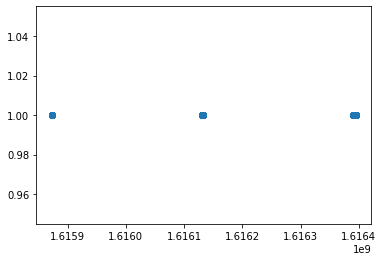

In [ ]:
timings0 = []
timings1 = []
for id in df2:
  if df2[id]['timestamp']['value']['_seconds'] > 1616408300:
    timings1.append(df2[id]['timestamp']['value']['_seconds'])
  else:
    timings0.append(df2[id]['timestamp']['value']['_seconds'])
plt.scatter(timings0, [1]* len(timings0))
plt.scatter(timings1, [1]* len(timings1))

In [ ]:
df2clean = pd.DataFrame(columns=all_cols)

for id in df2:
  if df2[id]['timestamp']['value']['_seconds'] < 1616408300:
    continue
  datarow = {
      'locX': df2[id]['location']['x'],
      'locY': df2[id]['location']['y']
  }
  cleanrssi = {}
  for ssid in df2[id].data:
    cleanrssi[ssid] = np.mean(df2[id].data[ssid])
  for i in range(len(goodssids)):
    if goodssids[i] in cleanrssi:
      datarow[f'r{i}v']     = 1
      #datarow[f'r{i}rssi']  = 1.01**cleanrssi[goodssids[i]]
      datarow[f'r{i}rssi']  = cleanrssi[goodssids[i]] / -100
    else:
      datarow[f'r{i}v']     = 0
      datarow[f'r{i}rssi']  = -1
  df2clean = df2clean.append(datarow, ignore_index=True)
df2clean.describe()

,locX,locY,r0v,r1v,r2v,r3v,r4v,r5v,r6v,r7v,r8v,r9v,r10v,r11v,r12v,r13v,r14v,r15v,r16v,r17v,r18v,r19v,r20v,r21v,r22v,r23v,r24v,r25v,r26v,r27v,r28v,r29v,r30v,r31v,r32v,r33v,r34v,r35v,r36v,r37v,...,r10rssi,r11rssi,r12rssi,r13rssi,r14rssi,r15rssi,r16rssi,r17rssi,r18rssi,r19rssi,r20rssi,r21rssi,r22rssi,r23rssi,r24rssi,r25rssi,r26rssi,r27rssi,r28rssi,r29rssi,r30rssi,r31rssi,r32rssi,r33rssi,r34rssi,r35rssi,r36rssi,r37rssi,r38rssi,r39rssi,r40rssi,r41rssi,r42rssi,r43rssi,r44rssi,r45rssi,r46rssi,r47rssi,r48rssi,r49rssi
count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X2 = df2clean[rssicols]
y2 = df2clean[['locX', 'locY']]

In [ ]:
print(f'r2 {model.score(X2, y2)} mse {mean_squared_error(y2, model.predict(X2))}')

ValueError: ignored

In [ ]:
y2_pred = model.predict(X2)
print(mean_squared_error(y2, y2_pred))
y2_pred_x = [ x for x, y in model.predict(X2)]
y2_pred_y = [ 1 - y for x, y in model.predict(X2)]
fig, ax1 = plt.subplots(figsize=(15,15))
ax1.imshow(img, extent=[0, 1, 0, 1])
ax1.scatter((y2['locX']).tolist(), (1 - y2['locY']).tolist())
ax1.scatter(y2_pred_x, y2_pred_y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def process_rssi(df, rssi):
  scaler = MinMaxScaler()
  rssiCont = cs.fit_transform(rssi)

# LSTM MODEL 

In [ ]:
X_train = np.array(X_train)
X_train.shape


X_train = np.reshape(X_train, (1, X_train.shape[0], X_train.shape[1]))

X_train.shape

In [ ]:
X_test = np.array(X_test)
X_test.shape

X_test = np.reshape(X_test, (1, X_test.shape[0], X_test.shape[1]))
X_test.shape

In [ ]:
y_train = np.array(y_train)
y_train.shape 

y_train = np.reshape(y_train, (1, y_train.shape[0], y_train.shape[1]))
y_train.shape

In [ ]:
y_test = np.array(y_test)
y_test.shape

y_test = np.reshape(y_test, (1, y_test.shape[0], y_test.shape[1]))
y_test.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape=X_train.shape[1:]))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 2))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.summary()

regressor.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test))


In [ ]:
regressor.predict(X_train)

In [ ]:
X_train.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Softmax

regressor = Sequential()

regressor.add(Dense(units = 5000, input_shape=(100,)))
regressor.add(Softmax())

regressor.add(Dense(units = 2000))
regressor.add(Softmax())

regressor.add(Dense(units = 1000))
regressor.add(Softmax())

regressor.add(Dense(units = 2))

# regressor.add(LSTM(units = 50, return_sequences = True, input_shape=X_train.shape[1:]))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.2))

# regressor.add(Dense(units = 2))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.summary()

regressor.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test))

In [ ]:
y2_pred = regressor.predict(X_test)
print(mean_squared_error(y_test, y2_pred))
y2_pred_x = [ x for x, y in y2_pred]
y2_pred_y = [ 1 - y for x, y in y2_pred]
fig, ax1 = plt.subplots(figsize=(15,15))
ax1.imshow(img, extent=[0, 1, 0, 1])
#ax1.scatter((y_test['locX']).tolist(), (1 - y_test['locY']).tolist())
ax1.scatter(y2_pred_x, y2_pred_y)

In [ ]:
regressor.predict(X_test)

In [ ]:
!tar -cf package.tar ragul1.joblib
!xz -e -9 -vv -T2 package.tar
!ls -lash

xz: Filter chain: --lzma2=dict=64MiB,lc=3,lp=0,pb=2,mode=normal,nice=273,mf=bt4,depth=512
xz: Using up to 2 threads.
xz: 2,499 MiB of memory is required. The limiter is disabled.
xz: Decompression will need 65 MiB of memory.
package.tar (1/1)
  100 %     1,771.5 KiB / 503.1 MiB = 0.003   4.8 MiB/s       1:45             
total 518M
4.0K drwxr-xr-x 1 root root 4.0K Apr 19 10:20  .
4.0K drwxr-xr-x 1 root root 4.0K Apr 19 08:29  ..
528K -rw-r--r-- 1 root root 527K Apr 19 08:31 'B2L2 Cleaned Floor Plan-1.png'
4.0K drwxr-xr-x 4 root root 4.0K Apr  7 13:35  .config
 24K -rw-r--r-- 1 root root  24K Apr 19 09:15  good_ssids.txt
4.0K drwxr-xr-x 2 root root 4.0K Apr 19 08:31  .ipynb_checkpoints
 24K -rw-r--r-- 1 root root  21K Apr 19 09:55  LEGAL_POINTS.json
1.8M -rw-r--r-- 1 root root 1.8M Apr 19 10:19  package.tar.xz
504M -rw-r--r-- 1 root root 504M Apr 19 10:15  ragul1.joblib
4.0K drwxr-xr-x 1 root root 4.0K Apr  7 13:36  sample_data
 12M -rw-r--r-- 1 root root  12M Apr 19 08:34  trackie_data